In [1]:
conda install -c conda-forge lightgbm

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import time
import numpy as np
import pandas as pd
import lightgbm
import re
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

### Table of Contents <a class="anchor" id="table1"></a>

### [I-Préparation initiale dataset](#chapter1)
   
### [II-Modèle](#chapter2)


# I-nettoyage et Exploration Datasets <a class="anchor" id="chapter1"></a>

##### [Table of Contents](#table1)

In [112]:
# List of available files
print(os.listdir("Projet_Mise_en_prod_home_credit_default_risk"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


Dataset Description

* application_{train|test}.csv

    * Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

* bureau.csv

    * Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

* bureau_balance.csv

    * Soldes mensuels des crédits antérieurs au bureau de crédit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .

* POS_CASH_balance.csv

    * Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

* credit_card_balance.csv

    * Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

* previous_application.csv

    * Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

* installments_payments.csv

    * Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

* HomeCredit_columns_description.csv

    * Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [194]:
appli_train = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/application_train.csv")
print('Application train shape: ', appli_train.shape)
appli_train.head(2)

Application train shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
appli_train.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [180]:
appli_train.duplicated().sum()

0

### Observons les Types de données

In [181]:
# Nombre de variables par type
appli_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

> On constate qu'on a 3 types de données `float64`, `int64`et `object`;
- On a 16 variables catégorielles;
- Un modèle de machine learning ne peut pas traiter ces variables catégorielles (exception de certains modèles comme`LightGBM`). Il faudra encoder ces variables pour pouvoir les utiliser dans notre modèle. Nous utiliserons un **One-Hot Encoding** pour l'encodage des variables catégorielles, notamment la fonction `get_dummies(df)` de Pandas.

### Observons les valeurs manquantes dans notre dataset

In [150]:
#fonction pour calculer pour chaque colonne du dataset son taux de remplissage
def taux_remplissage(df):

    tab_colonne = {}
    
    for col in df.columns:
        tab_colonne[col] = []
        tab_colonne[col].append(round((df[col].notna().sum()/df.shape[0])*100,3))
        #.iloc[:,1] != 0
        tab_colonne[col].append(df[col].isna().sum())
        tableau_remplissage = pd.DataFrame.from_dict(tab_colonne, orient="index", columns = ["Taux de remplissage", "Nombre de valeurs manquantes"]).sort_values(by="Taux de remplissage", ascending=True)
    return tableau_remplissage

In [157]:
#Nombre de colonne qui a des valeurs manquantes
((taux_remplissage(appli_train).iloc[:,1])!= 0).sum()

67

> Il y a 67 colonnes (sur 122) qui ont des valeurs manquantes. Nous verrons par la suite, si nous faisons une imputation par la moyenne pour remplacer ces valeurs manquantes ou si nous supprimons tout simplement ces colonnes. Mais dans le deuxième cas, il est difficile de savoir si les variables avec valeurs manquantes serviront pour notre modèle ou pas. Donc, le 2ème cas sera écarté pour le moment.

In [183]:
appli_test = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/application_test.csv")
print('Application test shape: ', appli_test.shape)
appli_test.head(2)

Application test shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [10]:
appli_test.describe(include="all")

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48305,32678,32311,33658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,277796.676350,NaN,NaN,NaN,NaN,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,NaN,NaN,NaN,NaN,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,NaN,NaN,NaN,NaN,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,NaN,NaN,NaN,NaN,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,NaN,NaN,NaN,NaN,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


In [11]:
appli_test.duplicated().sum()

0

##### [Table of Contents](#table1)

###  1ere branche

In [117]:
bureau = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/bureau.csv")
print('Bureau shape: ', bureau.shape)
bureau.head(2)

Bureau shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [116]:
appli_test = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/application_test.csv")
print('Application test shape: ', appli_test.shape)
appli_test.head(2)

Application test shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [14]:
bureau.describe(include='all')  

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


In [15]:
bureau.duplicated().sum()

0

<AxesSubplot:>

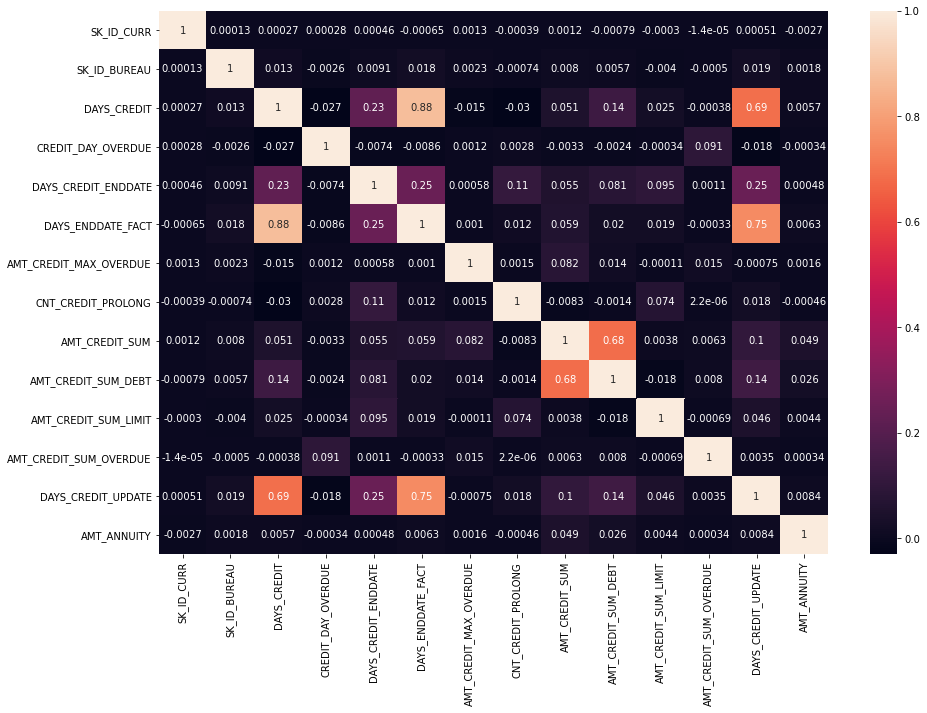

In [16]:
#correlation
plt.figure(figsize=(15, 10))
sns.heatmap(bureau.corr(), annot=True) 

In [115]:
bureau_bal = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/bureau_balance.csv")
print('Bureau Balance shape: ', bureau_bal.shape)
bureau_bal.head(2)

Bureau Balance shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


In [19]:
bureau_bal.describe(include='all')  

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


In [20]:
bureau_bal.duplicated().sum()

0

### 2nd branche

In [118]:
pre_appli = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/previous_application.csv")
print('Previous Application shape: ', pre_appli.shape)
pre_appli.head(2)

Previous Application shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [23]:
pre_appli.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,...,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,...,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,...,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,...,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,...,NaN,1.456729e+01,NaN,NaN,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,...,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,...,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,...,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,...,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


In [24]:
pre_appli.duplicated().sum()

0

In [119]:
pos_cash_bal = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/POS_CASH_balance.csv")
print('POS CASH balance shape: ', pos_cash_bal.shape)
pos_cash_bal.head(2)

POS CASH balance shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [27]:
pos_cash_bal.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


In [28]:
pos_cash_bal.duplicated().sum()

0

In [120]:
inst_paym = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/installments_payments.csv")
print('Installments Payments shape: ', inst_paym.shape)
inst_paym.head(2)

Installments Payments shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [30]:
inst_paym.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [32]:
inst_paym.duplicated().sum()

0

In [121]:
cc_bal = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/credit_card_balance.csv")
print('Credit Card Balance shape: ', cc_bal.shape)
cc_bal.head(2)

Credit Card Balance shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [35]:
cc_bal.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


In [36]:
cc_bal.duplicated().sum()

0

<AxesSubplot:>

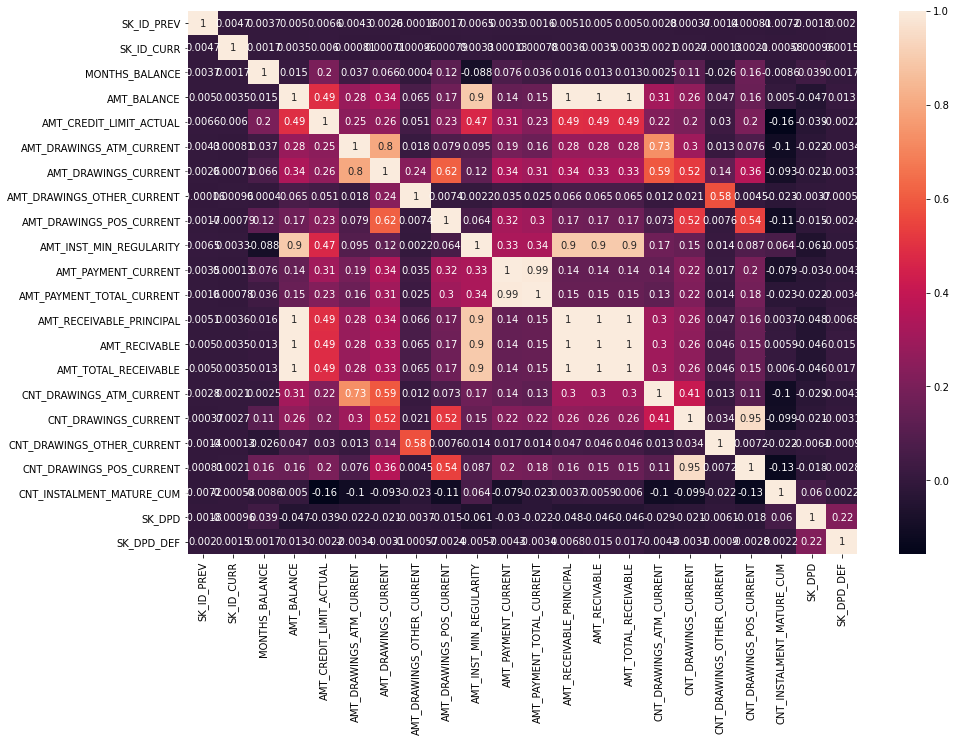

In [37]:
#correlation
plt.figure(figsize=(15, 10))
sns.heatmap(cc_bal.corr(), annot=True) 

* La corrélation entre AMT_BALANCE et AMT_INST_MIN_REGULARITY est élevé =0.9;
* La corrélation entre AMT_BALANCE et AMT_RECEIVABLE_PRINCIPAL et AMT_RECEIVABLE et AMT_TOTAL_RECEIVABLE) est très élevé =1;
* La corrélation entre AMT_DRAWING_ATM_CURRENT et AMT_DRAWINGS_CURRENT (=0.8) et CNT_DRAWINGS_CURRENT(=0.73) est très élevé;
* La corrélation entre AMT_DRAWING_CURRENT et AMT_DRAWING_POS_CURRENT (=0.62) et CNT_DRAWING_ATM_CURRENT(=0.59) est  élevé;
* La corrélation entre AMT_INST_MIN_REGULARITY et AMT_RECEIVABLE_PRINCIPAL et AMT_RECEIVABLE et AMT_TOTAL_RECEIVABLE) est très élevé =0.9;
* La corrélation entre AMT_PAYMENT_CURRENT et AMT_PAYMENT_TOTAL_CURRENT est très élevé =0.99;
* La corrélation entre CNT_DRAWING_POS_CURRENT et CNT_DRAWINGS_CURRENT(=0.95) est très élevé;

#### Fichier de description des data

In [122]:
homecredit_desc = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/HomeCredit_columns_description.csv")
print('HomeCredit columns description shape: ', homecredit_desc.shape)
homecredit_desc.head(2)

HomeCredit columns description shape:  (219, 5)


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN


In [40]:
homecredit_desc.duplicated().sum()

0

In [41]:
#exporter dans un tableur pour lire les descriptions
homecredit_desc.to_csv("homecredit_description_colonnes.csv", sep='\t')

In [123]:
samp_sub = pd.read_csv("Projet_Mise_en_prod_home_credit_default_risk/sample_submission.csv")
print('Sample Submission shape: ', samp_sub.shape)
samp_sub.head(2)

Sample Submission shape:  (48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5


In [44]:
samp_sub.describe(include='all')  

,SK_ID_CURR,TARGET
count,48744.000000,48744.0
mean,277796.676350,0.5
std,103169.547296,0.0
min,100001.000000,0.5
25%,188557.750000,0.5
50%,277549.000000,0.5
75%,367555.500000,0.5
max,456250.000000,0.5


In [45]:
samp_sub.duplicated().sum()

0

### Analyse Exploratoire des données

##### [Table of Contents](#table1)

On va analyser `application_train`

In [125]:
appli_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:>

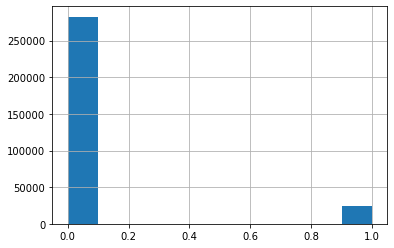

In [49]:
appli_train.TARGET.hist()

Pour information, on a deux classes pour la `TARGET` variable:
- 1 = client en difficulté de paiement : il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du crédit de notre échantillon;
- 0 = tous les autres cas;
On peut observer qu'il s'agit d'un problème de classe déséquilibré (**Imbalanced Classe**) . Il y a beaucoup plus de prêts qui n'ont pas eu de problème de paiement que de prêts qui ont eu des diffilculté de paiement été. ce problème avec des classes déséquilibrées en machine learning, peut être résolu en pondérant (**weight the classes**) les classes (représentation des données).

### Resampling
Dans le cas de données très déséquilibré comme ici, il existe des techniques de rééchantillonnage afin de rééquilibrer ces données. Pour cela nous allons utiliser la librairie `imblearn`.

Il existe deux techniques pour resampler les données :

- L'under-sampling : On supprime des individus de la classe majoritaire.
> Under-sampling: Tomek links
Les Tomek links sont des paires d'instances très proches, mais de classes opposées. La suppression des instances de la classe majoritaire de chaque paire augmente l'espace entre les deux classes, facilitant le processus de classification.
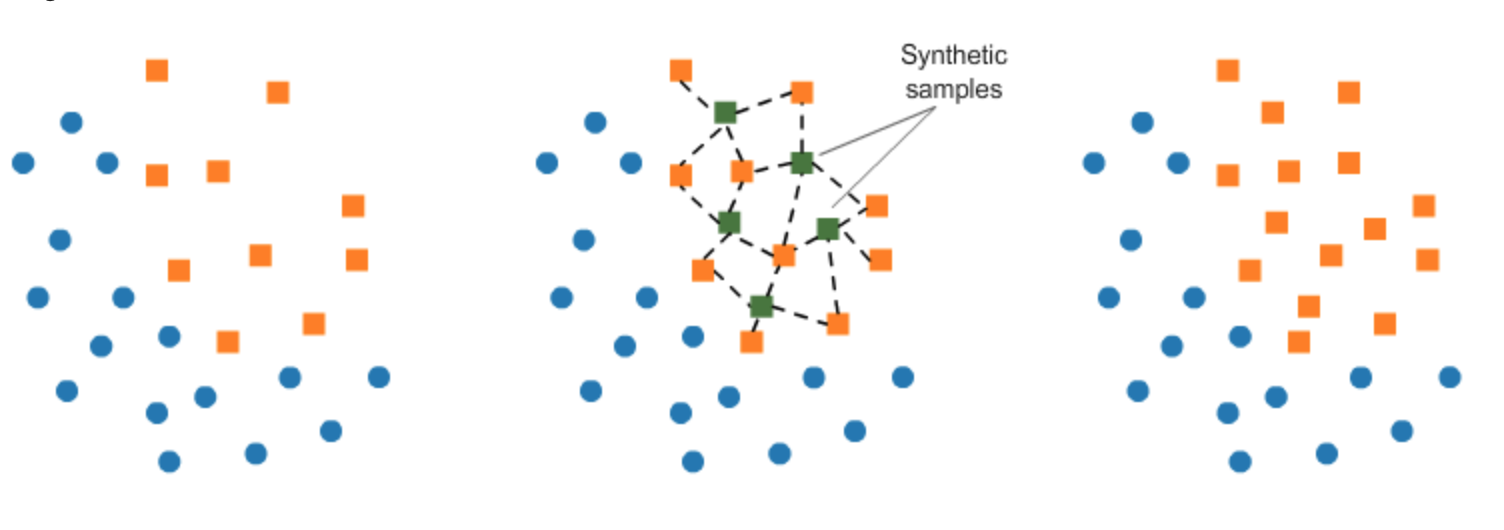
- L'over-sampling : On crée des individus dans la classe minoritaire.
> Over-sampling : SMOTE
SMOTE (Synthetic Minority Oversampling TEchnique) consiste à synthétiser des éléments pour la classe minoritaire, à partir de ceux qui existent déjà. Cela fonctionne en choisissant aléatoirement un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.
![Capture%20d%E2%80%99e%CC%81cran%202022-11-26%20a%CC%80%2000.27.17.png](attachment:Capture%20d%E2%80%99e%CC%81cran%202022-11-26%20a%CC%80%2000.27.17.png)

F    202448
M    105059
Name: CODE_GENDER, dtype: int64


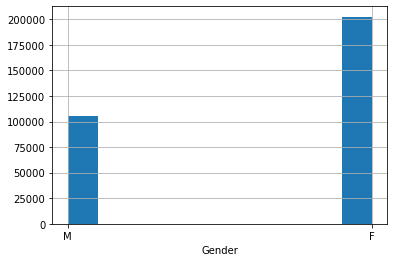

In [226]:
appli_train['CODE_GENDER'].hist()
plt.xlabel('Gender');
print(appli_train['CODE_GENDER'].value_counts())

> On observe qu'on a plus de femme qui emprunte que d'homme. On a 4 valeurs de genre XNA. On va les supprimer, cela n'aura peu d'impact sur notre modèle.

In [196]:
# On va supprimer "XNA" de "application_train"
appli_train = appli_train[appli_train['CODE_GENDER'] != 'XNA']

N    202922
Y    104585
Name: FLAG_OWN_CAR, dtype: int64


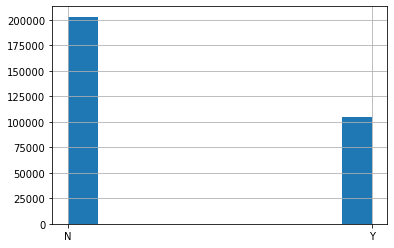

In [200]:
appli_train['FLAG_OWN_CAR'].hist()
print(appli_train['FLAG_OWN_CAR'].value_counts())

> On observe que presque qu'un tiers des emprunteurs sont propriétaires de leurs voitures.

Y    213308
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


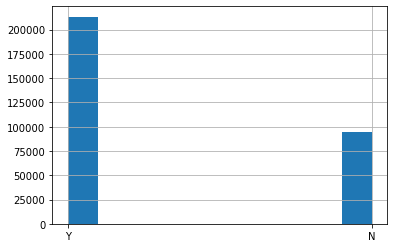

In [204]:
appli_train['FLAG_OWN_REALTY'].hist()
print(appli_train['FLAG_OWN_REALTY'].value_counts())

> On observe qu'un peu moins d'un tiers des emprunteurs ne sont pas propriétaires d'une maison ou d'un appartement.

In [210]:
#Combien de jours avant la demande, la personne a commencé son emploi actuel
appli_train['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

> La valeur max est positive et correspond à 365243 jours soit environ 1000 ans. la valeur est aberrante (Outlier).

In [213]:
# Âge du client en jours au moment de la demande
appli_train['DAYS_BIRTH'].describe()

count    307507.000000
mean     -16037.027271
std        4363.982424
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

> L'age des emprunteur semble correct. Elle varie de max à environs 20 ans à min à environs 69 ans. à 50%, on est à 43 ans environs.

In [214]:
# Revenu du client
appli_train['AMT_INCOME_TOTAL'].describe()

count    3.075070e+05
mean     1.687977e+05
std      2.371246e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

> Le revenu des clients sont dans un interval correct de revenu annuel entre 25650 (min) à 202500 (75%) à 117 millions (max). La valeur max semble être une valeur aberrante;

In [215]:
# Montant du crédit du prêt
appli_train['AMT_CREDIT'].describe()

count    3.075070e+05
mean     5.990286e+05
std      4.024926e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

> Le montant du crédit du prêt sont dans un interval de coût entre 45.000 (min) à 808.650 (75%) à 4.050.000 (max). La valeur max semble être une valeur aberrante;

In [219]:
# Combien de membres de la famille le client a-t-il
appli_train['CNT_FAM_MEMBERS'].describe()

count    307505.000000
mean          2.152658
std           0.910680
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

[ 1.  2.  3.  4.  5.  6.  9.  7.  8. 10. 13. nan 14. 12. 20. 15. 16. 11.]


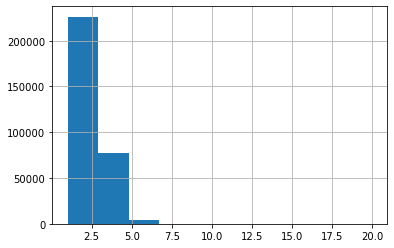

In [221]:
appli_train['CNT_FAM_MEMBERS'].hist()
print(appli_train['CNT_FAM_MEMBERS'].unique())

> Le nombre de membre dans la famille de l'emprunteur semble correct. Elle varie de max. à 20 membres à min. à  1 membre. à 75%, on a 3 membres dans la famille. La valeur max. est un outlier.

In [222]:
# Rente de prêt
appli_train['AMT_ANNUITY'].describe()

count    307495.000000
mean      27108.666786
std       14493.798379
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

> La rente de prêt varie de max. à environs 258025.5, et à min., on a 1615,5. A 50%, on est à 24903;

### Features Engineering

In [242]:
#Application train/test

[0.06732903 0.07086191 0.0118135  ... 0.52926634 0.40013377 0.07486948]


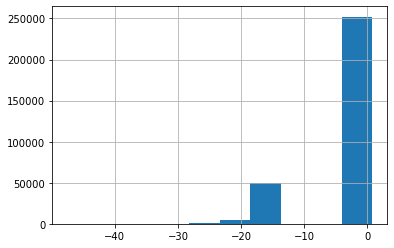

In [235]:
# Nombre de jour travaillé suivant son age avant la demande prêt (en%)
appli_train['DAYS_EMPLOYED_PERC'] = (appli_train['DAYS_EMPLOYED'] / appli_train['DAYS_BIRTH'])
appli_train['DAYS_EMPLOYED_PERC'].hist()
print(appli_train['DAYS_EMPLOYED_PERC'].unique())

[0.49803553 0.20873558 0.5        ... 0.15090198 0.20018223 0.46202855]


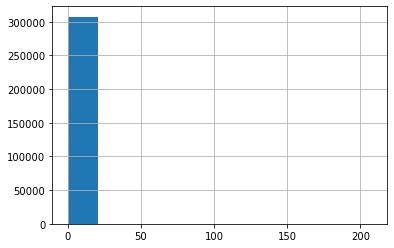

In [238]:
appli_train['INCOME_CREDIT_PERC'] = (appli_train['AMT_INCOME_TOTAL'] / appli_train['AMT_CREDIT'])
appli_train['INCOME_CREDIT_PERC'].hist()
print(appli_train['INCOME_CREDIT_PERC'].unique())

[202500.   135000.    67500.   ...  49178.25  48384.   273125.25]


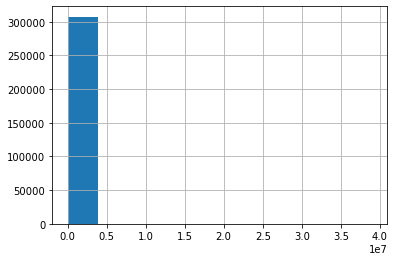

In [239]:
appli_train['INCOME_PER_PERSON'] = (appli_train['AMT_INCOME_TOTAL'] / appli_train['CNT_FAM_MEMBERS'])
appli_train['INCOME_PER_PERSON'].hist()
print(appli_train['INCOME_PER_PERSON'].unique())

[0.12197778 0.13221667 0.1        ... 0.13786207 0.10520588 0.19594118]


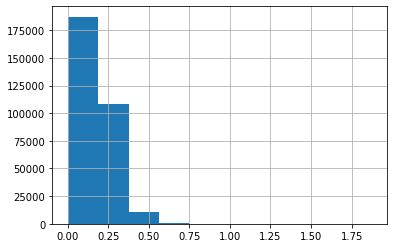

In [240]:
appli_train['ANNUITY_INCOME_PERC'] = (appli_train['AMT_ANNUITY'] / appli_train['AMT_INCOME_TOTAL'])
appli_train['ANNUITY_INCOME_PERC'].hist()
print(appli_train['ANNUITY_INCOME_PERC'].unique())

[0.06074927 0.02759832 0.05       ... 0.06408769 0.03591689 0.05583805]


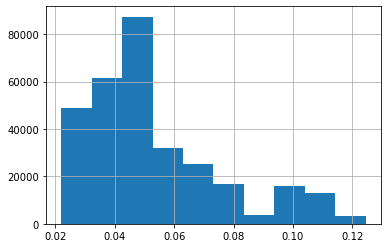

In [241]:
appli_train['PAYMENT_RATE'] = (appli_train['AMT_ANNUITY'] / appli_train['AMT_CREDIT'])
appli_train['PAYMENT_RATE'].hist()
print(appli_train['PAYMENT_RATE'].unique())

In [265]:
# bureau & bureau_balance

[5714462 5714463 5714464 ... 5057762 5057770 5057778]


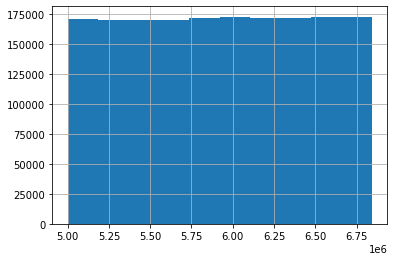

In [248]:
bureau['SK_ID_BUREAU'].hist()
print(bureau['SK_ID_BUREAU'].unique())

count    1.716428e+06
mean    -1.142108e+03
std      7.951649e+02
min     -2.922000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max      0.000000e+00
Name: DAYS_CREDIT, dtype: float64


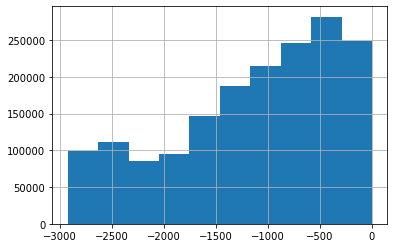

In [251]:
#Combien de jours avant la demande actuelle, le client a-t-il demandé un crédit au bureau de crédit
bureau['DAYS_CREDIT'].hist()
print(bureau['DAYS_CREDIT'].describe())

count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64


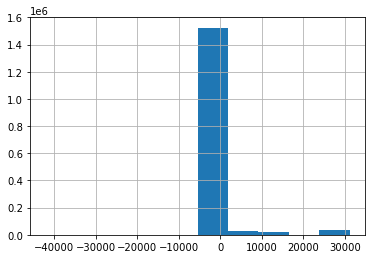

In [252]:
# Durée restante du crédit CB (en jours) au moment de la demande en Crédit Immobilier
bureau['DAYS_CREDIT_ENDDATE'].hist()
print(bureau['DAYS_CREDIT_ENDDATE'].describe())

count    1.716428e+06
mean    -5.937483e+02
std      7.207473e+02
min     -4.194700e+04
25%     -9.080000e+02
50%     -3.950000e+02
75%     -3.300000e+01
max      3.720000e+02
Name: DAYS_CREDIT_UPDATE, dtype: float64


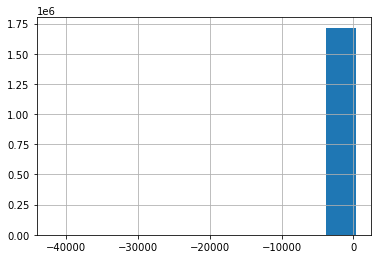

In [253]:
# Combien de jours avant la demande de prêt les dernières informations sur le crédit du bureau de crédit 
# sont-elles arrivées
bureau['DAYS_CREDIT_UPDATE'].hist()
print(bureau['DAYS_CREDIT_UPDATE'].describe())

count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64


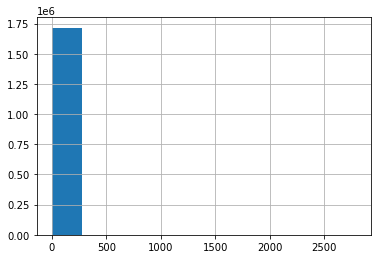

In [254]:
# Nombre de jours d'impayés sur crédit CB au moment de la demande de prêt connexe dans notre échantillon
bureau['CREDIT_DAY_OVERDUE'].hist()
print(bureau['CREDIT_DAY_OVERDUE'].describe())

count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64


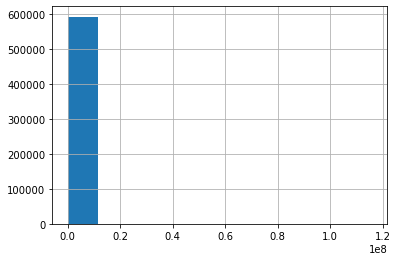

In [255]:
# Montant maximal en souffrance sur le crédit du bureau de crédit jusqu'à présent 
# (à la date de demande de prêt dans notre échantillon)
bureau['AMT_CREDIT_MAX_OVERDUE'].hist()
print(bureau['AMT_CREDIT_MAX_OVERDUE'].describe())

count    1.716415e+06
mean     3.549946e+05
std      1.149811e+06
min      0.000000e+00
25%      5.130000e+04
50%      1.255185e+05
75%      3.150000e+05
max      5.850000e+08
Name: AMT_CREDIT_SUM, dtype: float64


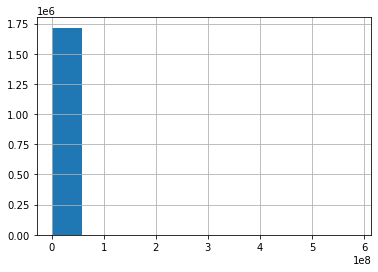

In [256]:
# Montant actuel du crédit pour le crédit du bureau de crédit
bureau['AMT_CREDIT_SUM'].hist()
print(bureau['AMT_CREDIT_SUM'].describe())

count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64


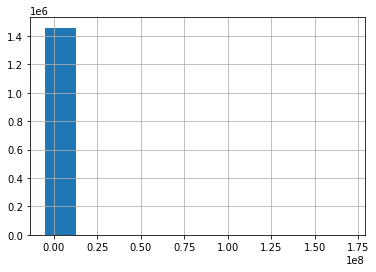

In [257]:
# Dette actuelle sur le crédit du Bureau de crédit
bureau['AMT_CREDIT_SUM_DEBT'].hist()
print(bureau['AMT_CREDIT_SUM_DEBT'].describe())

count    1.716428e+06
mean     3.791276e+01
std      5.937650e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.756681e+06
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64


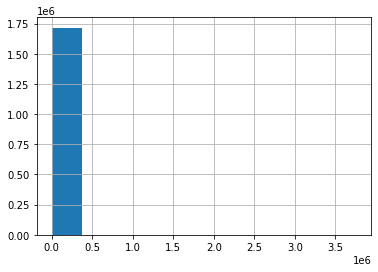

In [258]:
# Montant actuel en souffrance sur le crédit du bureau de crédit
bureau['AMT_CREDIT_SUM_OVERDUE'].hist()
print(bureau['AMT_CREDIT_SUM_OVERDUE'].describe())

count    1.124648e+06
mean     6.229515e+03
std      4.503203e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64


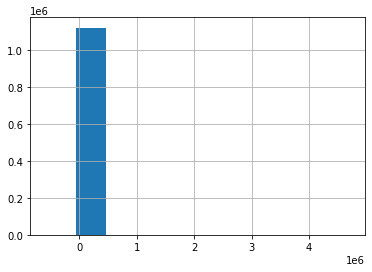

In [259]:
# Limite de crédit actuelle de la carte de crédit signalée au bureau de crédit
bureau['AMT_CREDIT_SUM_LIMIT'].hist()
print(bureau['AMT_CREDIT_SUM_LIMIT'].describe())

count    4.896370e+05
mean     1.571276e+04
std      3.258269e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.350000e+04
max      1.184534e+08
Name: AMT_ANNUITY, dtype: float64


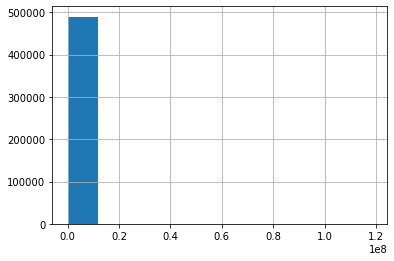

In [261]:
# Rente du Crédit Bureau de crédit
bureau['AMT_ANNUITY'].hist()
print(bureau['AMT_ANNUITY'].describe())

count    1.716428e+06
mean     6.410406e-03
std      9.622391e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.000000e+00
Name: CNT_CREDIT_PROLONG, dtype: float64
[0 2 1 4 3 5 9 8 6 7]


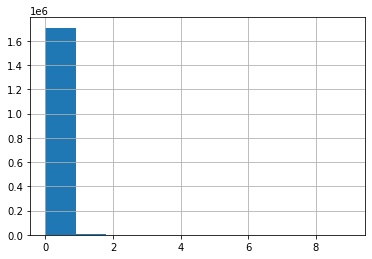

In [263]:
# Combien de fois le crédit du bureau de crédit a-t-il été prolongé
bureau['CNT_CREDIT_PROLONG'].hist()
print(bureau['CNT_CREDIT_PROLONG'].describe())
print(bureau['CNT_CREDIT_PROLONG'].unique())

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


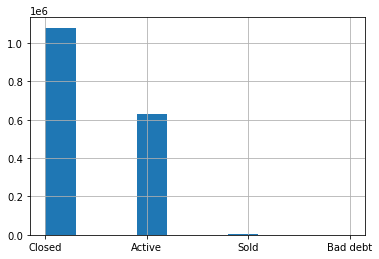

In [272]:
# Statut des crédits déclarés par la centrale des risques (CB)
bureau['CREDIT_ACTIVE'].hist()
print(bureau['CREDIT_ACTIVE'].value_counts())

In [273]:
# previous_applications

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64
 365243.0    934444
-228.0          123
-212.0          121
-224.0          121
-223.0          119
              ...  
-1544.0           1
-1887.0           1
-1579.0           1
-1733.0           1
-1895.0           1
Name: DAYS_FIRST_DRAWING, Length: 2838, dtype: int64


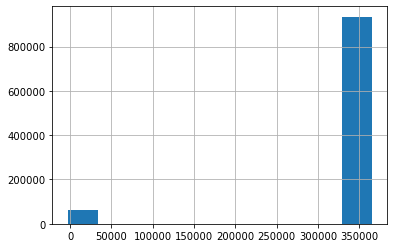

In [274]:
# Statut des crédits déclarés par la centrale des risques (CB)
pre_appli['DAYS_FIRST_DRAWING'].hist()
print(pre_appli['DAYS_FIRST_DRAWING'].describe())
print(pre_appli['DAYS_FIRST_DRAWING'].value_counts())

count     1716428
unique          4
top        Closed
freq      1079273
Name: CREDIT_ACTIVE, dtype: object
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


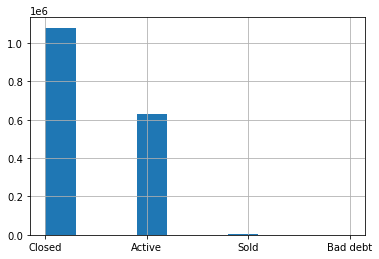

In [271]:
# Statut des crédits déclarés par la centrale des risques (CB)
bureau['CREDIT_ACTIVE'].hist()
print(bureau['CREDIT_ACTIVE'].describe())
print(bureau['CREDIT_ACTIVE'].value_counts())

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64


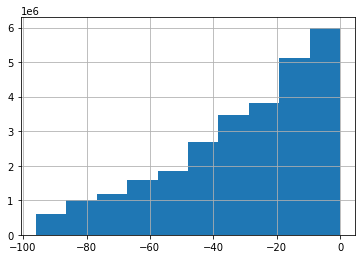

In [278]:
# Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)
bureau_bal['MONTHS_BALANCE'].hist()
print(bureau_bal['MONTHS_BALANCE'].describe())
#print(bureau_bal['MONTHS_BALANCE'].value_counts())

In [ ]:
# previous_applications

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64


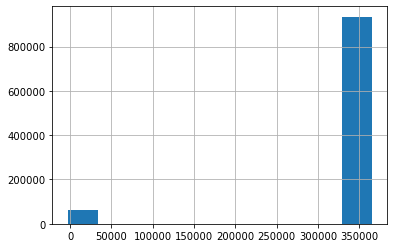

In [282]:
# Par rapport à la date d'application de l'application actuelle, à quand remonte le premier décaissement 
# de l'application précédente
pre_appli['DAYS_FIRST_DRAWING'].hist()
print(pre_appli['DAYS_FIRST_DRAWING'].describe())
#print(pre_appli['DAYS_FIRST_DRAWING'].value_counts())

count    997149.000000
mean      13826.269337
std       72444.869708
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64


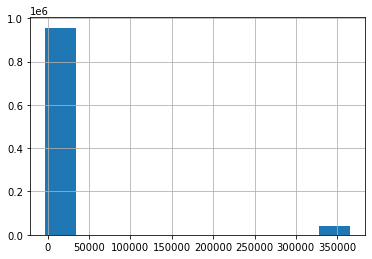

In [283]:
# Par rapport à la date de demande de la demande en cours, quand était la première échéance 
# censée être de la demande précédente
pre_appli['DAYS_FIRST_DUE'].hist()
print(pre_appli['DAYS_FIRST_DUE'].describe())
#print(pre_appli['DAYS_FIRST_DUE'].value_counts())

count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64


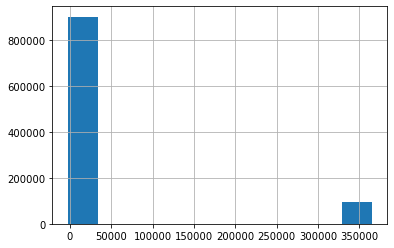

In [285]:
# Par rapport à la date de demande de la demande actuelle quand était la première échéance de la demande précédente
pre_appli['DAYS_LAST_DUE_1ST_VERSION'].hist()
print(pre_appli['DAYS_LAST_DUE_1ST_VERSION'].describe())
#print(pre_appli['DAYS_LAST_DUE_1ST_VERSION'].value_counts())

count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64


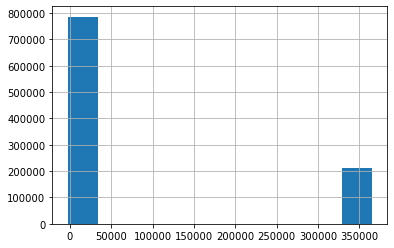

In [287]:
# PPar rapport à la date d'application de l'application actuelle quand était la dernière date 
# d'échéance de l'application précédente
pre_appli['DAYS_LAST_DUE'].hist()
print(pre_appli['DAYS_LAST_DUE'].describe())
#print(pre_appli['DAYS_LAST_DUE'].value_counts())

count    997149.000000
mean      81992.343838
std      153303.516729
min       -2874.000000
25%       -1270.000000
50%        -499.000000
75%         -44.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64


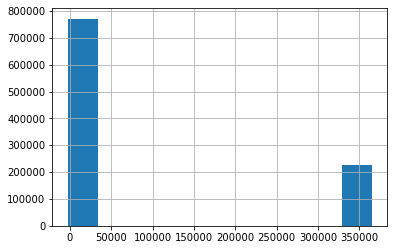

In [288]:
# Par rapport à la date de candidature de la candidature actuelle, quelle était la fin prévue 
# de la candidature précédente
pre_appli['DAYS_TERMINATION'].hist()
print(pre_appli['DAYS_TERMINATION'].describe())
#print(pre_appli['DAYS_TERMINATION'].value_counts())

In [292]:
# Par rapport à la date de candidature de la candidature actuelle, quelle était la fin prévue
pre_appli['APP_CREDIT_PERC'] = pre_appli['AMT_APPLICATION'] / pre_appli['AMT_CREDIT']
#pre_appli['APP_CREDIT_PERC'].hist()
print(pre_appli['APP_CREDIT_PERC'].describe())
#print(pre_appli['APP_CREDIT_PERC'].value_counts())

count    1.333446e+06
mean              inf
std               NaN
min      0.000000e+00
25%      8.959282e-01
50%      1.000000e+00
75%      1.011023e+00
max               inf
Name: APP_CREDIT_PERC, dtype: float64


# II-Modèle <a class="anchor" id="chapter2"></a>

##### [Table of Contents](#table1)

In [185]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)v
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.
# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [92]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [93]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [94]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [95]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [96]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [97]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [98]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [99]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('Projet_Mise_en_prod_home_credit_default_risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [104]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):#,sampling=False, sampling_method="SMOTE"
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        ####inclure methodes oversampling/smote/.. unqiuement sur entrainement##### rajouter argument dans la fct 
        ##### pour savoir si on fait oversampling ou pas
   
        #  if sampling = True :
        #        if sampling_method == "SMOTE":
        #            sampling avec smote "code"
         #       else if sampling_method =="oversampling"
         #           sampling avec oevrsampling
         #       else if sampling_method =="undersampling"
         #           sampling avec undersampling
               
                    
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d ROC_AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        #print('Fold %2d F1 : %.6f' % (n_fold + 1, f1_score(valid_y, oof_preds[valid_idx],average='micro')))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full roc_auc_score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    #print('Full f1_score %.6f' % f1_score(train_df['TARGET'], oof_preds[valid_idx],average=None))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [105]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 34s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 69s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 25s
Installments payments df shape: (339587, 26)
Process installments payments - done in 74s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 66s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796937	training's binary_logloss: 0.234847	valid_1's auc: 0.775923	valid_1's binary_logloss: 0.24683
[400]	training's auc: 0.819329	training's binary_logloss: 0.225295	valid_1's auc: 0.786496	valid_1's binary_logloss: 0.24275
[600]	training's auc: 0.834077	training's binary_logloss: 0.219246	valid_1's auc: 0.790546	valid_1's binary_logloss: 0.241363
[800]	training's auc: 0.846244	training's binary_logloss: 0.214265	valid_1's auc: 0.79268	valid_1's binary_logloss: 0.240699
[1000]	training's auc: 0.856872	training's binary_logloss: 0.209823	valid_1's auc: 0.793482	valid_1's binary_logloss: 0.240434
[1200]	training's auc: 0.86648	training's binary_logloss: 0.205634	valid_1's auc: 0.79366	valid_1's binary_logloss: 0.240392
[1400]	training's auc: 0.875651	training's binary_logloss: 0.20155	valid_1's auc: 0.794104	valid_1's binary_logloss: 0.240215
Fo

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796462	training's binary_logloss: 0.235586	valid_1's auc: 0.777631	valid_1's binary_logloss: 0.241585
[400]	training's auc: 0.819242	training's binary_logloss: 0.226005	valid_1's auc: 0.787068	valid_1's binary_logloss: 0.237332
[600]	training's auc: 0.834123	training's binary_logloss: 0.219917	valid_1's auc: 0.78934	valid_1's binary_logloss: 0.236293
[800]	training's auc: 0.846391	training's binary_logloss: 0.214876	valid_1's auc: 0.790548	valid_1's binary_logloss: 0.235757
[1000]	training's auc: 0.856678	training's binary_logloss: 0.210503	valid_1's auc: 0.791014	valid_1's binary_logloss: 0.235566
[1200]	training's auc: 0.865973	training's binary_logloss: 0.20648	valid_1's auc: 0.791596	valid_1's binary_logloss: 0.235375
[1400]	training's auc: 0.874713	training's binary_logloss: 0.202511	valid_1's auc: 0.791933	valid_1's binary_logloss: 0.23528

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797132	training's binary_logloss: 0.235046	valid_1's auc: 0.767687	valid_1's binary_logloss: 0.246557
[400]	training's auc: 0.81996	training's binary_logloss: 0.225444	valid_1's auc: 0.77791	valid_1's binary_logloss: 0.242608
[600]	training's auc: 0.835202	training's binary_logloss: 0.219235	valid_1's auc: 0.781536	valid_1's binary_logloss: 0.241409
[800]	training's auc: 0.847245	training's binary_logloss: 0.214215	valid_1's auc: 0.783418	valid_1's binary_logloss: 0.240803
[1000]	training's auc: 0.857679	training's binary_logloss: 0.209766	valid_1's auc: 0.784392	valid_1's binary_logloss: 0.240532
[1200]	training's auc: 0.867101	training's binary_logloss: 0.205683	valid_1's auc: 0.785058	valid_1's binary_logloss: 0.240354
[1400]	training's auc: 0.87575	training's binary_logloss: 0.201753	valid_1's auc: 0.785493	valid_1's binary_logloss: 0.240265

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796643	training's binary_logloss: 0.235567	valid_1's auc: 0.777877	valid_1's binary_logloss: 0.241276
[400]	training's auc: 0.819156	training's binary_logloss: 0.226009	valid_1's auc: 0.788309	valid_1's binary_logloss: 0.236995
[600]	training's auc: 0.834196	training's binary_logloss: 0.21995	valid_1's auc: 0.791755	valid_1's binary_logloss: 0.235604
[800]	training's auc: 0.84632	training's binary_logloss: 0.214967	valid_1's auc: 0.793333	valid_1's binary_logloss: 0.234996
[1000]	training's auc: 0.856691	training's binary_logloss: 0.210573	valid_1's auc: 0.794132	valid_1's binary_logloss: 0.234647
[1200]	training's auc: 0.866348	training's binary_logloss: 0.206389	valid_1's auc: 0.794958	valid_1's binary_logloss: 0.234393
[1400]	training's auc: 0.875354	training's binary_logloss: 0.202301	valid_1's auc: 0.794843	valid_1's binary_logloss: 0.23436

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796369	training's binary_logloss: 0.236335	valid_1's auc: 0.780337	valid_1's binary_logloss: 0.234085
[400]	training's auc: 0.818884	training's binary_logloss: 0.22677	valid_1's auc: 0.790259	valid_1's binary_logloss: 0.229877
[600]	training's auc: 0.83386	training's binary_logloss: 0.220605	valid_1's auc: 0.793516	valid_1's binary_logloss: 0.22852
[800]	training's auc: 0.845971	training's binary_logloss: 0.215625	valid_1's auc: 0.795396	valid_1's binary_logloss: 0.227822
[1000]	training's auc: 0.856275	training's binary_logloss: 0.211244	valid_1's auc: 0.796494	valid_1's binary_logloss: 0.227456
[1200]	training's auc: 0.865939	training's binary_logloss: 0.20709	valid_1's auc: 0.796766	valid_1's binary_logloss: 0.227291
[1400]	training's auc: 0.874709	training's binary_logloss: 0.203146	valid_1's auc: 0.797064	valid_1's binary_logloss: 0.227182


/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797398	training's binary_logloss: 0.235298	valid_1's auc: 0.767261	valid_1's binary_logloss: 0.243325
[400]	training's auc: 0.819866	training's binary_logloss: 0.225733	valid_1's auc: 0.777851	valid_1's binary_logloss: 0.239515
[600]	training's auc: 0.83503	training's binary_logloss: 0.219527	valid_1's auc: 0.782064	valid_1's binary_logloss: 0.238106
[800]	training's auc: 0.847033	training's binary_logloss: 0.214624	valid_1's auc: 0.783549	valid_1's binary_logloss: 0.23758
[1000]	training's auc: 0.857572	training's binary_logloss: 0.210149	valid_1's auc: 0.784303	valid_1's binary_logloss: 0.237339
[1200]	training's auc: 0.867406	training's binary_logloss: 0.205849	valid_1's auc: 0.784483	valid_1's binary_logloss: 0.23728
[1400]	training's auc: 0.876192	training's binary_logloss: 0.201847	valid_1's auc: 0.784816	valid_1's binary_logloss: 0.237176

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797172	training's binary_logloss: 0.235543	valid_1's auc: 0.774688	valid_1's binary_logloss: 0.240667
[400]	training's auc: 0.819833	training's binary_logloss: 0.225917	valid_1's auc: 0.784718	valid_1's binary_logloss: 0.236479
[600]	training's auc: 0.834499	training's binary_logloss: 0.219892	valid_1's auc: 0.788047	valid_1's binary_logloss: 0.235226
[800]	training's auc: 0.846932	training's binary_logloss: 0.2148	valid_1's auc: 0.78929	valid_1's binary_logloss: 0.234801
[1000]	training's auc: 0.857464	training's binary_logloss: 0.210402	valid_1's auc: 0.790351	valid_1's binary_logloss: 0.234474
[1200]	training's auc: 0.86698	training's binary_logloss: 0.206283	valid_1's auc: 0.790849	valid_1's binary_logloss: 0.234352
[1400]	training's auc: 0.875721	training's binary_logloss: 0.202355	valid_1's auc: 0.791013	valid_1's binary_logloss: 0.234306


/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797316	training's binary_logloss: 0.235083	valid_1's auc: 0.770296	valid_1's binary_logloss: 0.245427
[400]	training's auc: 0.819666	training's binary_logloss: 0.225482	valid_1's auc: 0.781593	valid_1's binary_logloss: 0.241074
[600]	training's auc: 0.834464	training's binary_logloss: 0.219429	valid_1's auc: 0.785653	valid_1's binary_logloss: 0.239628
[800]	training's auc: 0.846072	training's binary_logloss: 0.214642	valid_1's auc: 0.787682	valid_1's binary_logloss: 0.238965
[1000]	training's auc: 0.856682	training's binary_logloss: 0.210216	valid_1's auc: 0.78876	valid_1's binary_logloss: 0.238628
[1200]	training's auc: 0.866414	training's binary_logloss: 0.205959	valid_1's auc: 0.789357	valid_1's binary_logloss: 0.23845
[1400]	training's auc: 0.874928	training's binary_logloss: 0.20211	valid_1's auc: 0.789995	valid_1's binary_logloss: 0.23824


/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796263	training's binary_logloss: 0.235509	valid_1's auc: 0.780875	valid_1's binary_logloss: 0.242467
[400]	training's auc: 0.819252	training's binary_logloss: 0.225838	valid_1's auc: 0.790693	valid_1's binary_logloss: 0.238019
[600]	training's auc: 0.834388	training's binary_logloss: 0.219661	valid_1's auc: 0.793886	valid_1's binary_logloss: 0.236687
[800]	training's auc: 0.846738	training's binary_logloss: 0.214579	valid_1's auc: 0.795072	valid_1's binary_logloss: 0.23613
[1000]	training's auc: 0.857665	training's binary_logloss: 0.210009	valid_1's auc: 0.795723	valid_1's binary_logloss: 0.235826
[1200]	training's auc: 0.867117	training's binary_logloss: 0.20588	valid_1's auc: 0.796098	valid_1's binary_logloss: 0.235662
[1400]	training's auc: 0.87602	training's binary_logloss: 0.201917	valid_1's auc: 0.796278	valid_1's binary_logloss: 0.235604

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' a

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796938	training's binary_logloss: 0.235608	valid_1's auc: 0.771538	valid_1's binary_logloss: 0.240887
[400]	training's auc: 0.819469	training's binary_logloss: 0.226103	valid_1's auc: 0.78221	valid_1's binary_logloss: 0.236783
[600]	training's auc: 0.834552	training's binary_logloss: 0.219942	valid_1's auc: 0.786034	valid_1's binary_logloss: 0.235417
[800]	training's auc: 0.846485	training's binary_logloss: 0.215037	valid_1's auc: 0.787553	valid_1's binary_logloss: 0.234844
[1000]	training's auc: 0.857397	training's binary_logloss: 0.210453	valid_1's auc: 0.788835	valid_1's binary_logloss: 0.234445
[1200]	training's auc: 0.867034	training's binary_logloss: 0.206277	valid_1's auc: 0.789107	valid_1's binary_logloss: 0.234291
[1400]	training's auc: 0.875902	training's binary_logloss: 0.202268	valid_1's auc: 0.789512	valid_1's binary_logloss: 0.2341

<ipython-input-104-588ee0a10900>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 7658s
Full model run - done in 7938s


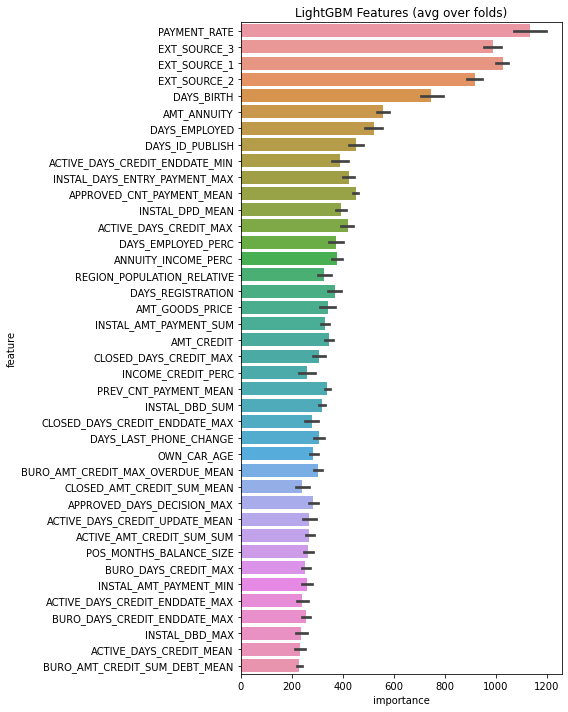

In [106]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()